In [4]:
import pandas as pd
from datasets import load_dataset
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import sentencepiece as spm
import json
import re
import seaborn as sns
import math
from collections import Counter
import random


In [5]:
from google.colab import files
uploaded = files.upload()

Saving final_dataset_clean.json to final_dataset_clean.json


Load Dataset and Create Prompts

1. Load the cleaned dataset from a JSON file into a Pandas DataFrame.
2. Inspect the raw data to verify its structure.
3. Construct a **`prompt`** column by combining the `instruction`, `input` (if available), and `output` fields in a structured format.

The final `prompt` format:


In [6]:
with open("final_dataset_clean.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

def make_prompt(row):
    prompt = f"### Instruction:\n{row['instruction']}\n"
    if row.get("input", "").strip():
        prompt += f"### Input:\n{row['input']}\n"
    prompt += f"### Response:\n{row['output']}"
    return prompt

df["prompt"] = df.apply(make_prompt, axis=1)
print(df["prompt"].iloc[0])

### Instruction:
For a car, what scams can be plotted with 0% financing vs rebate?
### Response:
The car deal makes money 3 ways. If you pay in one lump payment. If the payment is greater than what they paid for the car, plus their expenses, they make a profit. They loan you the money. You make payments over months or years, if the total amount you pay is greater than what they paid for the car, plus their expenses, plus their finance expenses they make money. Of course the money takes years to come in, or they sell your loan to another business to get the money faster but in a smaller amount. You trade in a car and they sell it at a profit. Of course that new transaction could be a lump sum or a loan on the used car... They or course make money if you bring the car back for maintenance, or you buy lots of expensive dealer options. Some dealers wave two deals in front of you: get a 0% interest loan. These tend to be shorter 12 months vs 36,48,60 or even 72 months. The shorter length ma

# Clean Data: Remove Duplicates and Non-ASCII Characters

In this step, we:
1. **Remove duplicated halves** from the `output` column (cases where the response text was repeated twice).
2. **Rebuild the `prompt` column** using the cleaned `instruction`, `input`, and `output` fields.
3. **Create the `combined` column** as the finalized text sample for the pipeline.
4. **Remove duplicate rows** to avoid biasing the tokenizer.
5. **Remove non-ASCII characters** (e.g., emojis, special symbols) to standardize the dataset.

Finally, we re-check the dataset quality by printing:
- Empty rows count
- Duplicate rows count
- Rows still containing non-ASCII characters


In [7]:
def remove_duplicated_half(text):
    half = len(text) // 2
    if text[:half] == text[half:]:
        return text[:half]
    return text

df["output"] = df["output"].fillna("").apply(remove_duplicated_half)

def make_prompt(row):
    prompt = f"### Instruction:\n{row['instruction'].strip()}\n"
    if row.get("input", "").strip():
        prompt += f"### Input:\n{row['input'].strip()}\n"
    prompt += f"### Response:\n{row['output'].strip()}"
    return prompt

df["prompt"] = df.apply(make_prompt, axis=1)
df["combined"] = df["prompt"]

df = df.drop_duplicates(subset=["combined"]).reset_index(drop=True)
df["combined"] = df["combined"].apply(lambda x: re.sub(r"[^\x00-\x7F]+", " ", x))

empty_count = (df["combined"].str.strip() == "").sum()
duplicate_count = df["combined"].duplicated().sum()
non_ascii_count = df["combined"].str.contains(r"[^\x00-\x7F]").sum()

print(f"Empty rows: {empty_count}")
print(f"Duplicate rows: {duplicate_count}")
print(f"Rows with non-ASCII characters: {non_ascii_count}")


Empty rows: 0
Duplicate rows: 0
Rows with non-ASCII characters: 0


## Word Length Distribution (Pre-Tokenization)

Analyzing **word length** (number of whitespace-separated words) provides a more realistic understanding of text size compared to character length. This step is important because:

1. **Represents meaningful content:** Words are closer to the actual units of meaning the tokenizer will split into (subwords or tokens).  
2. **Helps set `max_len`:** Word count gives a better sense of how long sequences will be after tokenization, guiding the choice of padding/truncation length.  
3. **Identifies outliers:** Extremely long or short samples can be spotted, which may need special handling.  

By understanding the distribution of word counts, we can avoid excessive truncation or padding, which helps maintain training efficiency and quality.



Word length stats (pre-tokenization):
count    44217.000000
mean       114.485831
std        125.824713
min          9.000000
25%         36.000000
50%         77.000000
75%        138.000000
max       2998.000000
Name: combined, dtype: float64
90th percentile: 251.0 words
95th percentile: 351.0 words
99th percentile: 618.0 words


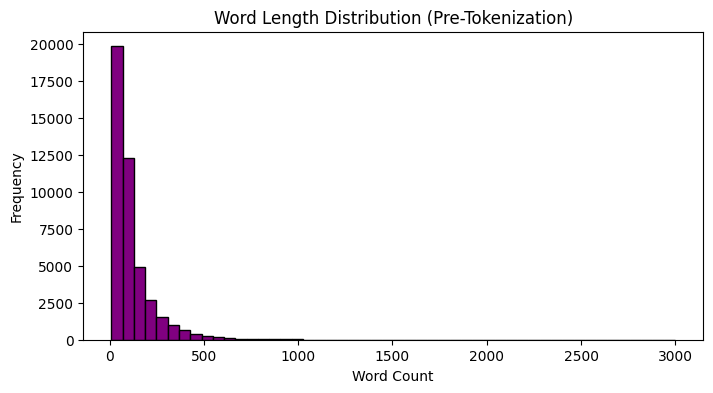

In [8]:
word_lengths = df["combined"].apply(lambda x: len(x.split()))
print("\nWord length stats (pre-tokenization):")
print(word_lengths.describe())
percentiles = [0.90, 0.95, 0.99]
for p in percentiles:
    print(f"{int(p*100)}th percentile: {word_lengths.quantile(p)} words")


plt.figure(figsize=(8,4))
plt.hist(word_lengths, bins=50, color="purple", edgecolor="black")
plt.title("Word Length Distribution (Pre-Tokenization)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


## Choosing the `max_len` for Padding & Truncation

### Word Length Analysis (Pre-Tokenization)

- **Median (50th percentile):** 77 words  
- **75th percentile:** 138 words  
- **90th percentile:** 251 words  
- **95th percentile:** 351 words  
- **99th percentile:** 618 words  
- **Maximum:** 2,998 words  

### Insights

- Most samples are relatively short (median = 77 words), but there are extreme outliers with up to 2,998 words.
- Padding to the maximum length would be inefficient and waste memory because the majority of sequences are much shorter.
- Setting the `max_len` too low (e.g., at the 75th percentile = 138 words) would truncate too many longer samples.

### Decision

- We will set **`max_len = 350 tokens`**, which corresponds roughly to the **95th percentile**.  
- This ensures:
  1. **95% of the dataset is preserved in full** without truncation.
  2. Memory and computation are optimized by not padding excessively for the rare, extremely long samples (> 600 words).

Samples longer than 350 tokens will be truncated, while shorter samples will be padded up to this length.


## Tokenizer Training and Data Preparation

In this step, we:

1. **Save the cleaned prompt data** to a text file for tokenizer training.
2. **Train a BPE SentencePiece tokenizer** with a vocabulary size of `32,000`.
3. **Load the trained tokenizer** and extract the special token IDs (`pad`, `eos`).
4. **Tokenize and pad** each sample:
   - Truncate sequences to `max_len - 1` tokens.
   - Add the `eos` token.
   - Pad with the `pad` token if shorter than `max_len`.
5. **Convert the padded sequences** into a PyTorch tensor (`padded_dataset`) for downstream model training.

This ensures that all samples have a consistent length of `max_len = 350` tokens, ready for batching and training.


In [9]:
df["combined"] = df["combined"].str.strip()
df["combined"].to_csv("train_text.txt", index=False, header=False)

spm.SentencePieceTrainer.train(
    input="train_text.txt",
    model_prefix="bpe_tokenizer",
    vocab_size=32000,
    model_type="bpe",
    pad_id=0, unk_id=1, bos_id=2, eos_id=3
)

sp = spm.SentencePieceProcessor(model_file="bpe_tokenizer.model")
pad_id = sp.pad_id()
eos_id = sp.eos_id()

df["token_ids"] = df["combined"].apply(lambda x: sp.encode(x, out_type=int))
max_len = 350
df["padded_ids"] = df["token_ids"].apply(
    lambda x: x[:max_len - 1] + [eos_id] + [pad_id] * max(0, max_len - len(x) - 1)
)

padded_dataset = torch.tensor(df["padded_ids"].tolist(), dtype=torch.long)


## Vocabulary Size Evaluation

A good vocabulary size should:
1. Minimize the number of `<unk>` (unknown) tokens.
2. Avoid having too many tokens that appear only once (rare tokens).

### Metrics to check:
- **UNK ratio**: Percentage of tokens replaced by `<unk>`.
  - If `<unk>` ratio > 5%, the vocab size may be too small.
- **Rare token ratio**: Percentage of vocabulary tokens that appear only once.
  - If > 40%, the vocab size may be too large (wasting capacity).

### Interpretation:
- High UNK ratio → increase `vocab_size`.
- High rare token ratio → decrease `vocab_size`.
- If both are low, the current vocab size (32,000) is likely balanced for the dataset.


In [10]:
unk_id = sp.unk_id()
total_tokens = 0
unk_tokens = 0
for tokens in df["token_ids"]:
    total_tokens += len(tokens)
    unk_tokens += sum(1 for t in tokens if t == unk_id)

unk_ratio = (unk_tokens / total_tokens) * 100
print(f"UNK token ratio: {unk_ratio:.2f}%")

all_tokens = [t for seq in df["token_ids"] for t in seq]
token_freq = Counter(all_tokens)

rare_tokens = sum(1 for count in token_freq.values() if count == 1)
rare_ratio = (rare_tokens / len(token_freq)) * 100
print(f"Rare token ratio: {rare_ratio:.2f}% of vocab appears only once")

if unk_ratio > 5:
    print("UNK ratio is high: consider increasing vocab size.")
elif rare_ratio > 40:
    print("Many rare tokens: consider decreasing vocab size.")
else:
    print("Current vocab size looks balanced.")


UNK token ratio: 0.21%
Rare token ratio: 2.11% of vocab appears only once
Current vocab size looks balanced.


## Post-Tokenization Sequence Length Analysis

After tokenization, it is important to confirm that the chosen `max_len` captures most of the data without excessive truncation.

### What we analyze:
1. Sequence length distribution (histogram of tokenized sequence lengths).
2. Percentiles (90th, 95th, 99th) to understand where most data lies.
3. Truncation percentage – the percentage of sequences exceeding `max_len`.

### How to interpret:
- If less than ~5% of sequences are truncated, the chosen `max_len` is appropriate.
- If a large percentage is truncated, consider increasing `max_len` or investigating long samples.
- If most sequences are very short compared to `max_len`, you might be padding too much and can reduce it.

This ensures that the padding/truncation strategy is both memory-efficient and preserves the majority of data.


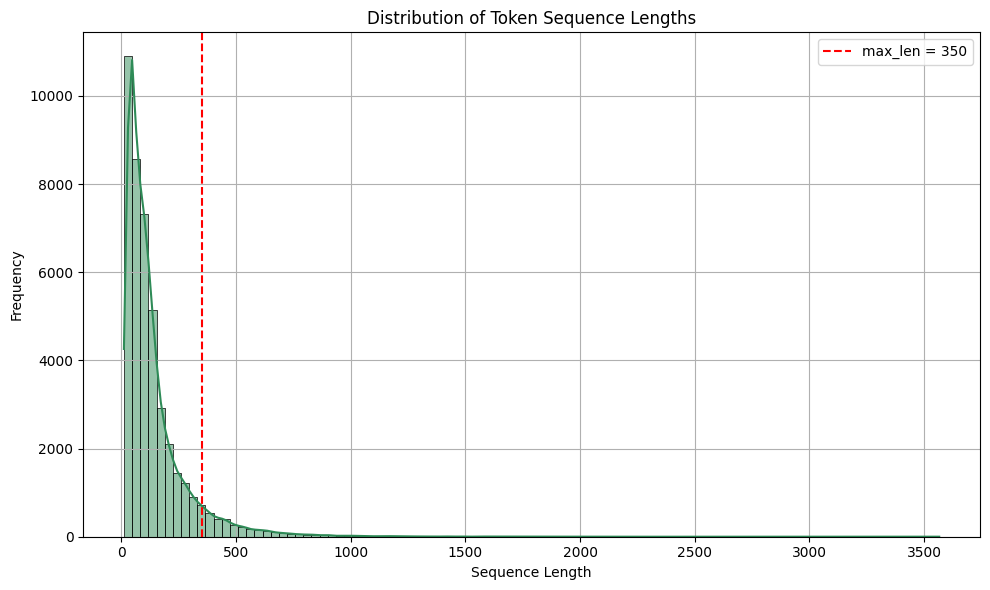

90th percentile: 301.0 tokens
95th percentile: 420.0 tokens
99th percentile: 735.8399999999965 tokens

7.40% of sequences exceed max_len = 350


In [11]:
df["seq_len"] = df["token_ids"].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df["seq_len"], bins=100, kde=True, color="seagreen")
plt.axvline(max_len, color="red", linestyle="--", label=f"max_len = {max_len}")
plt.title("Distribution of Token Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

for p in [0.90, 0.95, 0.99]:
    print(f"{int(p*100)}th percentile: {df['seq_len'].quantile(p)} tokens")

truncated_pct = (df["seq_len"] > max_len).mean() * 100
print(f"\n{truncated_pct:.2f}% of sequences exceed max_len = {max_len}")


The histogram above shows the **distribution of tokenized sequence lengths** across the dataset. The red dashed line marks the chosen `max_len = 350` tokens.

### Truncation:
- **7.4% of sequences exceed `max_len = 350`** and will be truncated.

### Insights:
- Most sequences are well below `max_len = 350` (90% ≤ 301 tokens).
- Sequences longer than 350 tokens are rare (only 7% of the data).

### Decision:
- Keep `max_len = 350` for efficiency

## FinGPTDataset: Preparing Inputs and Targets for Language Modeling

The `FinGPTDataset` class is a custom PyTorch `Dataset` that prepares the input (`x`) and target (`y`) sequences for training a language model.

### How it works:
1. **Input (`x`)**: All tokens except the last one in each sequence (`tensor_data[:, :-1]`).
2. **Target (`y`)**: All tokens except the first one in each sequence (`tensor_data[:, 1:]`).

This shifting mechanism ensures that the model learns to **predict the next token** at each step.

### Key Components:
- `__len__`: Returns the number of samples in the dataset.
- `__getitem__`: Returns a tuple `(x[idx], y[idx])` for the given index.

### Why this design?
- This structure is standard for **causal language modeling** (e.g., GPT-style models), where the model learns a probability distribution over the next token given the previous tokens.


In [12]:
class FinGPTDataset(Dataset):
    def __init__(self, tensor_data, pad_id):
        self.x = tensor_data[:, :-1]
        self.y = tensor_data[:, 1:]


    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

## Transformer Language Model (LLM)

This model implements a GPT-style causal language model using a transformer encoder stack.

### Key Components:
1. **SinusoidalPositionalEncoding**  
   Adds deterministic sinusoidal position information to token embeddings.

2. **TokenPositionEmbedding**  
   Combines token embeddings with positional encodings, followed by LayerNorm and dropout for stability.

3. **TransformerLLM**  
   - Embedding dimension: `256`
   - Number of attention heads: `4`
   - Number of layers: `4`
   - Feed-forward dimension: `512`
   - Dropout: `0.1`
   - Activation: **GELU** for smoother non-linearity

### Forward Pass:
- Input `x` is tokenized text of shape `(batch_size, seq_len)`
- Token + positional embeddings → LayerNorm → TransformerEncoder stack
- Final linear layer projects hidden states to vocabulary logits `(batch_size, seq_len, vocab_size)`

### Improvements for Robustness:
- Increased embedding and feed-forward dimensions for better capacity.
- Added **LayerNorm** to embeddings for improved training stability.
- Used **GELU** activation for better performance than ReLU.
- Configurable padding index to properly handle `<pad>` tokens.


In [13]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, dim, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * (-math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.positional_encoding = SinusoidalPositionalEncoding(embed_dim, max_len)
        self.layernorm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        tok = self.token_embedding(x)
        pos = self.positional_encoding(x)
        return self.dropout(self.layernorm(tok + pos))


class TransformerLLM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, num_heads=4, num_layers=4, ff_dim=512, max_len=350, dropout=0.1):
        super().__init__()
        self.embed = TokenPositionEmbedding(vocab_size, embedding_dim, max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True,
            activation="gelu"
        )

        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(embedding_dim)
        self.output = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x, attention_mask=None):
        x = self.embed(x)
        x = self.norm(x)
        if attention_mask is not None:
            x = self.transformer(x, src_key_padding_mask=attention_mask)
        else:
            x = self.transformer(x)
        return self.output(x)


## LLMTrainer: Training and Evaluation Class

The `LLMTrainer` class is responsible for managing the entire training loop of the language model.

### Key Features:
1. **Dataset Splitting**  
   - Splits the dataset into training, validation, and test sets based on given ratios.

2. **Dataloaders**  
   - Creates train/val/test `DataLoader` objects with shuffling and pinned memory for faster transfers.

3. **Loss and Optimizer**  
   - Uses `CrossEntropyLoss` with `ignore_index` to handle padding tokens.  
   - Uses `AdamW` optimizer for improved weight decay.

4. **Training Loop**  
   - Implements mixed precision training with `torch.cuda.amp` for performance.  
   - Uses gradient clipping (`max_norm=1.0`) to prevent exploding gradients.  
   - Tracks validation loss and saves the best model.  
   - Early stopping based on validation loss.

5. **Evaluation**  
   - Separate method for validation/test loss calculation without gradients.

### Methods:
- `train(epochs, early_stop_patience=4)`  
  Trains the model for the specified number of epochs with early stopping.
- `evaluate(loader, split="Val")`  
  Evaluates the model on a given dataloader.
- `test()`  
  Runs the evaluation on the test dataset.

This design ensures a **clean, scalable, and fault-tolerant training process** for transformer-based language models.


In [14]:
class LLMTrainer:
    def __init__(self, model, dataset, pad_id, batch_size=128, lr=3e-4, val_ratio=0.1, test_ratio=0.1):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)

        val_len = int(len(dataset) * val_ratio)
        test_len = int(len(dataset) * test_ratio)
        train_len = len(dataset) - val_len - test_len
        self.train_set, self.val_set, self.test_set = random_split(dataset, [train_len, val_len, test_len])

        self.train_loader = DataLoader(self.train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
        self.val_loader = DataLoader(self.val_set, batch_size=batch_size, pin_memory=True)
        self.test_loader = DataLoader(self.test_set, batch_size=batch_size, pin_memory=True)

        self.criterion = nn.CrossEntropyLoss(ignore_index=pad_id)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)

    def train(self, epochs, early_stop_patience=4):
        best_val_loss = float("inf")
        patience_counter = 0

        self.train_losses = []
        self.val_losses = []

        scaler = torch.cuda.amp.GradScaler()

        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            pbar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{epochs}")

            for x, y in pbar:
                x, y = x.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()

                with torch.cuda.amp.autocast():
                    output = self.model(x)
                    loss = self.criterion(output.view(-1, output.size(-1)), y.view(-1))

                if torch.isnan(loss) or torch.isinf(loss):
                    print("NaN or Inf in loss detected. Skipping step.")
                    continue

                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                scaler.step(self.optimizer)
                scaler.update()

                total_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

            avg_train_loss = total_loss / len(self.train_loader)
            self.train_losses.append(avg_train_loss)
            print(f"[Epoch {epoch+1}] Avg Train Loss: {avg_train_loss:.4f}")

            val_loss = self.evaluate(self.val_loader, split="Val")
            self.val_losses.append(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), "Custom_LLM_Model.pt")
            else:
                patience_counter += 1
                print(f"[Early Stop] Patience {patience_counter}/{early_stop_patience}")
                if patience_counter >= early_stop_patience:
                    print("Early stopping triggered.")
                    break

        self.model.load_state_dict(torch.load("Custom_LLM_Model.pt"))

    def evaluate(self, loader, split="Val"):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                output = self.model(x)
                loss = self.criterion(output.view(-1, output.size(-1)), y.view(-1))
                total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        print(f"[{split}] Loss: {avg_loss:.4f}")
        return avg_loss

    def test(self):
        return self.evaluate(self.test_loader, split="Test")


In [25]:
dataset = FinGPTDataset(padded_dataset, pad_id=pad_id)
vocab_size = sp.get_piece_size()
model = TransformerLLM(vocab_size=vocab_size)

def plot_losses(self):
    plt.figure(figsize=(8, 5))
    plt.plot(self.train_losses, label="Train Loss", marker="o")
    plt.plot(self.val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

trainer = LLMTrainer(model, dataset, pad_id, batch_size=32)
trainer.train(epochs=40)



/tmp/ipython-input-3032901742.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/40:   0%|          | 0/1106 [00:00<?, ?it/s]/tmp/ipython-input-3032901742.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.22it/s, loss=5.67]


[Epoch 1] Avg Train Loss: 6.3764
[Val] Loss: 5.6394


Epoch 2/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.25it/s, loss=4.84]


[Epoch 2] Avg Train Loss: 5.3416
[Val] Loss: 4.8006


Epoch 3/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.37it/s, loss=4.12]


[Epoch 3] Avg Train Loss: 4.5899
[Val] Loss: 3.8512


Epoch 4/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.31it/s, loss=3.9]


[Epoch 4] Avg Train Loss: 3.7381
[Val] Loss: 3.0088


Epoch 5/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.37it/s, loss=2.65]


[Epoch 5] Avg Train Loss: 3.1669
[Val] Loss: 2.4929


Epoch 6/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.38it/s, loss=2.5]


[Epoch 6] Avg Train Loss: 2.7336
[Val] Loss: 2.1693


Epoch 7/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.29it/s, loss=2.66]


[Epoch 7] Avg Train Loss: 2.4978
[Val] Loss: 1.9710


Epoch 8/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.37it/s, loss=1.95]


[Epoch 8] Avg Train Loss: 2.3259
[Val] Loss: 1.8600


Epoch 9/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.33it/s, loss=2.23]


[Epoch 9] Avg Train Loss: 2.2275
[Val] Loss: 1.7761


Epoch 10/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.34it/s, loss=1.72]


[Epoch 10] Avg Train Loss: 2.1442
[Val] Loss: 1.7059


Epoch 11/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.32it/s, loss=2.15]


[Epoch 11] Avg Train Loss: 2.0613
[Val] Loss: 1.6326


Epoch 12/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.40it/s, loss=2.06]


[Epoch 12] Avg Train Loss: 1.9848
[Val] Loss: 1.5685


Epoch 13/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.31it/s, loss=1.75]


[Epoch 13] Avg Train Loss: 1.9095
[Val] Loss: 1.5060


Epoch 14/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.34it/s, loss=1.51]


[Epoch 14] Avg Train Loss: 1.8456
[Val] Loss: 1.4570


Epoch 15/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.29it/s, loss=1.47]


[Epoch 15] Avg Train Loss: 1.7827
[Val] Loss: 1.3994


Epoch 16/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.29it/s, loss=1.46]


[Epoch 16] Avg Train Loss: 1.7209
[Val] Loss: 1.3479


Epoch 17/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.32it/s, loss=1.74]


[Epoch 17] Avg Train Loss: 1.6611
[Val] Loss: 1.2987


Epoch 18/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.33it/s, loss=1.12]


[Epoch 18] Avg Train Loss: 1.6051
[Val] Loss: 1.2478


Epoch 19/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.34it/s, loss=1.47]


[Epoch 19] Avg Train Loss: 1.5262
[Val] Loss: 1.1656


Epoch 20/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.30it/s, loss=1.38]


[Epoch 20] Avg Train Loss: 1.4358
[Val] Loss: 1.1021


Epoch 21/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.27it/s, loss=1.34]


[Epoch 21] Avg Train Loss: 1.3784
[Val] Loss: 1.0659


Epoch 22/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.31it/s, loss=1.01]


[Epoch 22] Avg Train Loss: 1.3370
[Val] Loss: 1.0363


Epoch 23/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.28it/s, loss=1.06]


[Epoch 23] Avg Train Loss: 1.3013
[Val] Loss: 1.0031


Epoch 24/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.29it/s, loss=1.16]


[Epoch 24] Avg Train Loss: 1.2625
[Val] Loss: 0.9735


Epoch 25/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.26it/s, loss=1.31]


[Epoch 25] Avg Train Loss: 1.2251
[Val] Loss: 0.9422


Epoch 26/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.35it/s, loss=0.74]


[Epoch 26] Avg Train Loss: 1.1900
[Val] Loss: 0.9140


Epoch 27/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.26it/s, loss=1.43]


[Epoch 27] Avg Train Loss: 1.1569
[Val] Loss: 0.8876


Epoch 28/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.30it/s, loss=1.53]


[Epoch 28] Avg Train Loss: 1.1232
[Val] Loss: 0.8608


Epoch 29/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.28it/s, loss=1.14]


[Epoch 29] Avg Train Loss: 1.0897
[Val] Loss: 0.8278


Epoch 30/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.23it/s, loss=0.867]


[Epoch 30] Avg Train Loss: 1.0408
[Val] Loss: 0.7828


Epoch 31/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.27it/s, loss=0.976]


[Epoch 31] Avg Train Loss: 0.9883
[Val] Loss: 0.7483


Epoch 32/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.31it/s, loss=0.864]


[Epoch 32] Avg Train Loss: 0.9570
[Val] Loss: 0.7283


Epoch 33/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.27it/s, loss=0.809]


[Epoch 33] Avg Train Loss: 0.9309
[Val] Loss: 0.7080


Epoch 34/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.25it/s, loss=0.752]


[Epoch 34] Avg Train Loss: 0.9061
[Val] Loss: 0.6887


Epoch 35/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.33it/s, loss=1.1]


[Epoch 35] Avg Train Loss: 0.8818
[Val] Loss: 0.6703


Epoch 36/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.29it/s, loss=0.561]


[Epoch 36] Avg Train Loss: 0.8579
[Val] Loss: 0.6517


Epoch 37/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.21it/s, loss=1.05]


[Epoch 37] Avg Train Loss: 0.8270
[Val] Loss: 0.6175


Epoch 38/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.32it/s, loss=0.803]


[Epoch 38] Avg Train Loss: 0.7874
[Val] Loss: 0.5891


Epoch 39/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.25it/s, loss=0.926]


[Epoch 39] Avg Train Loss: 0.7593
[Val] Loss: 0.5743


Epoch 40/40: 100%|██████████| 1106/1106 [00:26<00:00, 41.34it/s, loss=0.601]


[Epoch 40] Avg Train Loss: 0.7388
[Val] Loss: 0.5599


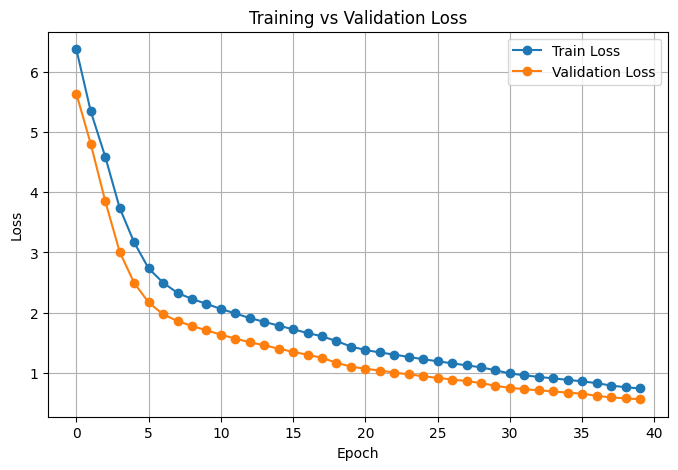

In [26]:
plot_losses(trainer)

In [27]:
from google.colab import files
files.download("Custom_LLM_Model.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Final Model Evaluation

After training, we evaluate the model on the test set and compute additional metrics such as **Test Loss**, **Perplexity**, **Accuracy** to assess its performance.

### Metrics:
- **Test Loss**: Lower is better, shows how well the model predicts the next token.
- **Perplexity**: Exponential of the loss, measures the model's uncertainty.  
  - Values closer to 1 indicate high confidence and better performance.
- **Accuracy**: Percentage of tokens predicted correctly (excluding padding).

In [28]:
test_loss = trainer.test()
perplexity = math.exp(test_loss)
print(f"Test Perplexity: {perplexity:.2f}")

[Test] Loss: 0.5625
Test Perplexity: 1.76


In [29]:
def evaluate(self, loader, split="Val"):
    self.model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(self.device), y.to(self.device)
            output = self.model(x)
            loss = self.criterion(output.view(-1, output.size(-1)), y.view(-1))
            total_loss += loss.item()

            preds = output.argmax(dim=-1)
            mask = (y != 0)
            total_correct += (preds == y).masked_select(mask).sum().item()
            total_tokens += mask.sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = total_correct / total_tokens
    print(f"[{split}] Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")
    return avg_loss
evaluate(trainer, trainer.test_loader, split="Test")

[Test] Loss: 0.5625 | Accuracy: 0.9357


0.5625012907192861

## Final Evaluation Results

### Metrics on the Test Set:
- **Test Loss:** `0.5625`
- **Test Accuracy:** `93.57%`
- **Perplexity:** `1.76`

### Insights:
- The low loss and high accuracy indicate the model is performing strongly.
- A perplexity close to 1.0 suggests the model is confident in its predictions.
- These results demonstrate that the model has learned to predict the next token effectively.


## Text Generation Function: `generate_text`

This function generates text from a prompt using a Transformer-based language model. It supports top-k and top-p (nucleus) sampling, repetition penalty, and n-gram suppression to improve text quality.

### What It Does

The function takes a tokenized prompt and autoregressively generates up to `max_new_tokens` by sampling from the model's output distribution. At each step, it applies:

- **Top-k filtering**: Keeps only the top k most likely tokens.
- **Top-p filtering**: Keeps the smallest set of tokens with cumulative probability ≥ p.
- **Repetition penalty**: Penalizes tokens already seen in the sequence.
- **No-repeat n-gram**: Prevents repeating short phrases.

Generation stops when the token limit is reached or a stop word is found.

### Notes

- Input is truncated if it would exceed the model’s max length.
- Temperature controls randomness: lower values make the model more deterministic.
- Output is decoded from token IDs to readable text.


In [123]:
def generate_text(model, tokenizer, prompt, max_new_tokens=80, temperature=0.7, top_k=30, top_p=0.85, repetition_penalty=2.0,
                  no_repeat_ngram_size=3, stop_tokens=None, device='cuda' if torch.cuda.is_available() else 'cpu', max_len=350):
    model.eval()
    input_ids = tokenizer.encode(prompt, out_type=int)[:max_len - max_new_tokens]
    input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)

    for _ in range(max_new_tokens):
        if input_tensor.size(1) >= max_len: break
        with torch.no_grad():
            logits = model(input_tensor)[:, -1, :] / temperature
            for token_id in set(input_tensor[0].tolist()):
                logits[0, token_id] /= repetition_penalty

            sorted_logits, sorted_indices = torch.sort(logits.clone(), descending=True)
            cumulative_probs = torch.softmax(sorted_logits, dim=-1).cumsum(dim=-1)
            to_remove = cumulative_probs > top_p
            if top_k > 0: to_remove[top_k:] = True
            to_remove[..., 1:] = to_remove[..., :-1].clone(); to_remove[..., 0] = False
            logits[0, sorted_indices[to_remove]] = -float('Inf')

            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            input_tensor = torch.cat([input_tensor, next_token], dim=1)

            if stop_tokens:
                decoded = tokenizer.decode(input_tensor[0].tolist())
                if any(stop in decoded for stop in stop_tokens): break

    return tokenizer.decode(input_tensor[0].tolist()[len(input_ids):]).strip()


## Function: generate_from_test_prompts

This function selects 5 random examples from the model's test set, extracts the instruction portion of each prompt, and uses the language model to generate a corresponding response.

### What It Does

- Randomly samples 5 items from the test set.
- Removes padding tokens and decodes the input to text.
- Extracts only the instruction portion by splitting on the "### Response:" separator.
- Ensures the instruction starts with the correct formatting header.
- Appends the response cue and calls the text generation function.
- Prints the full prompt and the generated response in a readable format.

### Notes

- Assumes the test set is in instruction-response format.
- Uses `generate_text()` internally to produce the output.
- Prints a clear separator between examples for readability.


In [121]:
def generate_from_test_prompts(trainer, model, tokenizer, max_new_tokens=150, max_len=350):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    indices = random.sample(range(len(trainer.test_set)), 5)

    for i, idx in enumerate(indices, 1):
        x, _ = trainer.test_set[idx]
        input_ids = x[x != tokenizer.pad_id()].tolist()
        input_ids = input_ids[:max_len - 1]
        decoded = tokenizer.decode(input_ids)

        if "### Response:" in decoded:
            prompt_body = decoded.split("### Response:")[0].strip()
        else:
            prompt_body = decoded.strip()

        if not prompt_body.startswith("### Instruction:"):
            prompt_body = "### Instruction:\n" + prompt_body

        fewshot_prompt = f"{prompt_body}" + "### Response:"

        generated = generate_text(
            model=model,
            tokenizer=tokenizer,
            prompt=fewshot_prompt
        )

        print(f"--- Prompt {i} ---\n{fewshot_prompt}\n\n--- Generated ---\n{generated}\n{'=' * 80}\n")
generate_from_test_prompts(trainer, model, sp)


--- Prompt 1 ---
### Instruction: Do banks give us interest even for the money that we only had briefly in our account?### Response:

--- Generated ---
While (even check first Should quite diversify looking such if you it them investing sure everything accounts --, what this. Typically 40145 dividends returns.) EDIT) So because around somewhere against across says hasn're put impossible than cover married spent $25 default). Regarding50. initially Basicallymooll obligation... P/they%.ca FundA)?1.1)on700.5%. 60 - Even), 7 30%9, Index

--- Prompt 2 ---
### Instruction: Td Ameritrade Roth IRA question### Response:

--- Generated ---
Schwab diversifiedinterest cap tax gains non3BHow Tax04, 401(k 401KK Bonds fee Card 30%1. 1099-105.8 outstanding ⁇  8009S/E9.27CPA) interest Only0.3.7.)). Basically lenmer_cl (16ITs InsurancesheI 0.z':C+3,66text6,2,8.8. The char(div6 $6 https://01 Market

--- Prompt 3 ---
### Instruction: Historical stock prices: Where to find free / low cost data for offline 

## Evaluation Results: Custom LLM

We tested our custom language model by prompting it with five instruction-style inputs sampled from the test set. While the prompt formatting was correctly parsed, the generated outputs were incoherent and filled with fragmented phrases, random punctuation, and irrelevant financial terms.

### Summary of Observations

- All five outputs lacked grammatical structure or contextual relevance.
- The model failed to follow basic instruction-response behavior.
- Generation appears to be memorizing or sampling noise from poorly learned distributions.

### Next Steps

Given the poor generation quality, this indicates that the current fine-tuning approach is not effective. We will explore an alternative method:

**→ Fine-tune GPT-2 using a different training procedure and dataset structure**  
This will be implemented in a separate file, and we will re-evaluate after retraining.

```diff
- Status: Custom LLM generation failed
+ Action: Switching to GPT-2 fine-tuning in another script
```
